# KMeans Clustering Example

A data set that identifies different types of iris's is used to demonstrate KMeans in SAP HANA.
## Iris Data Set
The data set used is from University of California, Irvine (https://archive.ics.uci.edu/ml/datasets/iris, for tutorials use only).  This data set contains attributes of a plant iris.  There are three species of Iris plants.
<table>
<tr><td>Iris Setosa</td><td><img src="images/Iris_setosa.jpg" title="Iris Sertosa" style="float:left;" width="300" height="50" /></td>
<td>Iris Versicolor</td><td><img src="images/Iris_versicolor.jpg" title="Iris Versicolor" style="float:left;" width="300" height="50" /></td>
<td>Iris Virginica</td><td><img src="images/Iris_virginica.jpg" title="Iris Virginica" style="float:left;" width="300" height="50" /></td></tr>
</table>

The data contains the following attributes for various flowers:
<table align="left"><tr><td>
<li align="top">sepal length in cm</li>
<li align="left">sepal width in cm</li>
<li align="left">petal length in cm</li>
<li align="left">petal width in cm</li>
</td><td><img src="images/sepal_petal.jpg" style="float:left;" width="200" height="40" /></td></tr></table>

Although the flower is identified in the data set, we will cluster the data set into 3 clusters since we know there are three different flowers.  The hope is that the cluster will correspond to each of the flowers.

A different notebook will use a classification algorithm to predict the type of flower based on the sepal and petal dimensions.

In [1]:
from hana_ml import dataframe
from hana_ml.algorithms.pal import clustering
import numpy as np
import pandas as pd
import logging
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

## Load data
The data is loaded into 4 tables - full set, test set, training set, and the validation set:
<li>IRIS_DATA_FULL_TBL</li>
<li>IRIS_DATA_TRAIN_TBL</li>
<li>IRIS_DATA_TEST_TBL</li>
<li>IRIS_DATA_VALIDATION_TBL</li>

To do that, a connection is created and passed to the loader.

There is a config file, <b>config/e2edata.ini</b> that controls the connection parameters and whether or not to reload the data from scratch.  In case the data is already loaded, there would be no need to load the data.  A sample section is below.  If the config parameter, reload_data is true then the tables for test, training, and validation are (re-)created and data inserted into them.

Although this ini file has other sections, please do not modify them.  Only the [hana] section should be modified.
#########################<br>
[hana]<br>
url=host.sjc.sap.corp<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>
<br>
#########################<br>

In [2]:
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_tbl, validation_tbl, test_tbl = DataSets.load_iris_data(connection_context)

Table IRIS_DATA_FULL_TBL exists and data exists


# Create Data Frames
Create the data frames for the full set since this is an unsupervised learning example.

Let us also do some data exploration.

## Define Dataset
Data frames are used keep references to data so computation on large data sets in HANA can happen in HANA.  Trying to bring the entire data set into the client will likely result in out of memory exceptions.

In [3]:
full_set = connection_context.table(full_tbl)

## Simple Exploration
Let us look at the number of rows in the data set

In [4]:
print('Number of rows in full set: {}'.format(full_set.count()))

Number of rows in full set: 150


### Let's look at the columns

In [5]:
print(full_set.columns)

['ID', 'SEPALLENGTHCM', 'SEPALWIDTHCM', 'PETALLENGTHCM', 'PETALWIDTHCM', 'SPECIES']


### Let us look at some rows

In [6]:
full_set.head(5).collect()

,ID,SEPALLENGTHCM,SEPALWIDTHCM,PETALLENGTHCM,PETALWIDTHCM,SPECIES
0,1,4.3,3.0,1.1,0.1,Iris-setosa
1,2,6.3,3.4,5.6,2.4,Iris-virginica
2,3,6.1,3.0,4.6,1.4,Iris-versicolor
3,4,6.4,3.2,4.5,1.5,Iris-versicolor
4,5,6.2,2.9,4.3,1.3,Iris-versicolor


### Let's look at the data types

In [7]:
full_set.dtypes()

[('ID', 'INT', 10, 10, 10, 0),
 ('SEPALLENGTHCM', 'DOUBLE', 15, 15, 15, 0),
 ('SEPALWIDTHCM', 'DOUBLE', 15, 15, 15, 0),
 ('PETALLENGTHCM', 'DOUBLE', 15, 15, 15, 0),
 ('PETALWIDTHCM', 'DOUBLE', 15, 15, 15, 0),
 ('SPECIES', 'NVARCHAR', 15, 15, 15, 0)]

### Let's check how many SPECIES are in the data set.

In [8]:
full_set.distinct("SPECIES").collect()

,SPECIES
0,Iris-setosa
1,Iris-versicolor
2,Iris-virginica


# Create Model
The lines below show the ease with which clustering can be done.

Set up the features and labels for the model and create the model

In [9]:
features = ['SEPALLENGTHCM','SEPALWIDTHCM','PETALLENGTHCM','PETALWIDTHCM']
label = ['SPECIES']

In [10]:
kmeans = clustering.KMeans(thread_ratio=0.2, n_clusters=3, distance_level='euclidean', 
                           max_iter=100, tol=1.0E-6, category_weights=0.5, normalization='min_max')
predictions = kmeans.fit_predict(full_set, 'ID', features).collect()
print(predictions)

      ID  CLUSTER_ID  DISTANCE  SLIGHT_SILHOUETTE
0      1           1  0.276043           0.695249
1      2           2  0.242288           0.556324
2      3           0  0.128990           0.676722
3      4           0  0.242409           0.293175
4      5           0  0.121434           0.728444
..   ...         ...       ...                ...
145  146           2  0.315820           0.536895
146  147           0  0.235348           0.336486
147  148           1  0.069393           0.905716
148  149           2  0.204936           0.305251
149  150           0  0.456985           0.393320

[150 rows x 4 columns]


# Plot the data

In [11]:
def plot_kmeans_results(data_set, features, predictions):
    # use this to estimate what each cluster_id represents in terms of flowers
    # ideal would be 50-50-50 for each flower, so we can see there are some mis clusterings
    class_colors = {0: 'r', 1: 'b', 2: 'k'}
    predictions_colors = [class_colors[p] for p in predictions['CLUSTER_ID'].values]

    red = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='r', label='Iris-virginica', markersize=10, alpha=0.9)
    blue = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='b', label='Iris-versicolor', markersize=10, alpha=0.9)
    black = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='k', label='Iris-setosa', markersize=10, alpha=0.9)

    for x, y in itertools.combinations(features, 2):
        plt.figure(figsize=(10,5))
        plt.scatter(full_set[[x]].collect(), data_set[[y]].collect(), c=predictions_colors, alpha=0.6, s=70)
        plt.grid()
        plt.xlabel(x, fontsize=15)
        plt.ylabel(y, fontsize=15)
        plt.tick_params(labelsize=15)
        plt.legend(handles=[red, blue, black])
        plt.show()

    %matplotlib notebook
    #above allows interactive 3d plot

    sizes=10
    for x, y, z in itertools.combinations(features, 3):
        fig = plt.figure(figsize=(8,5))

        ax = fig.add_subplot(111, projection='3d')
        ax.scatter3D(data_set[[x]].collect(), data_set[[y]].collect(), data_set[[z]].collect(), c=predictions_colors, s=70)
        plt.grid()

        ax.set_xlabel(x, labelpad=sizes, fontsize=sizes)
        ax.set_ylabel(y, labelpad=sizes, fontsize=sizes)
        ax.set_zlabel(z, labelpad=sizes, fontsize=sizes)
        ax.tick_params(labelsize=sizes)
        plt.legend(handles=[red, blue, black])
        plt.show()

In [12]:
print(pd.concat([predictions, full_set[['SPECIES']].collect()], axis=1).groupby(['SPECIES','CLUSTER_ID']).size())


SPECIES          CLUSTER_ID
Iris-setosa      1             50
Iris-versicolor  0             47
                 2              3
Iris-virginica   0             14
                 2             36
dtype: int64


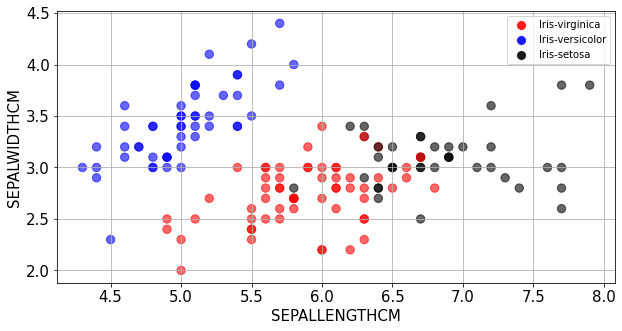

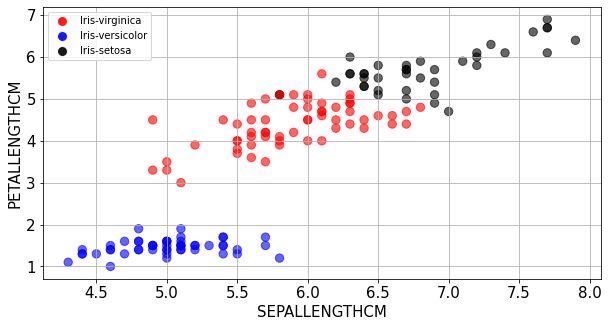

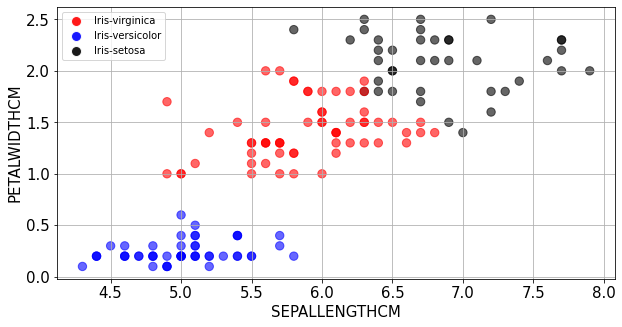

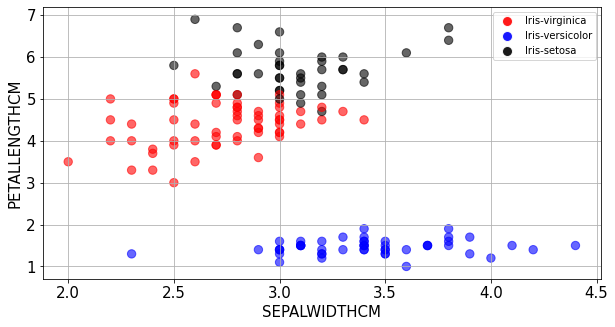

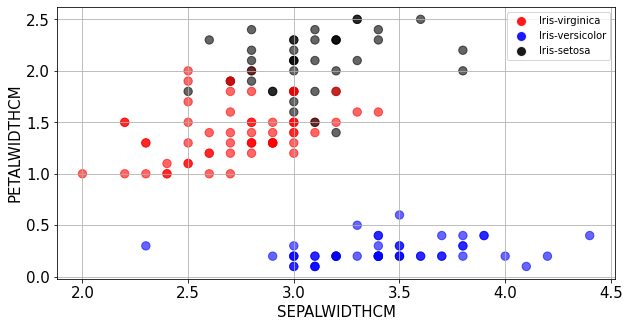

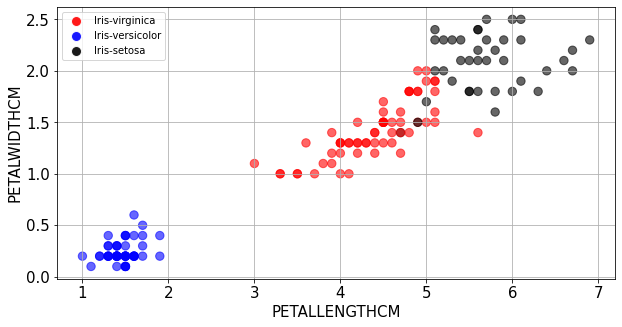

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
%matplotlib inline
plot_kmeans_results(full_set, features, predictions)